In [1]:
import os
import sys
sys.path.append(os.path.abspath("/Users/pratyushuppuluri/Desktop/Summer/CARL"))

import gymnasium as gym
import numpy as np 
import pandas as pd 
import pickle as pkl 
import tqdm 
import torch
import torch.nn as nn 
import torch.optim as optim 
import random

from torch.utils.data import DataLoader 
#from utils.utils import Specs

from ctrl_data import CollectRandomTransitions, TransitionDataset, BiCoGAN
from ctrl_models import Generator, Discriminator, Encoder
device = "cuda" if torch.cuda.is_available() else "cpu"


import math
import mlflow

In [7]:
envName = 'LunarLander-v3'
class Specs:
  def __init__(self,
               continuous: bool= False,
               gravity: float = -10.,
               enable_wind: bool = False,
               wind_power: float = 15.,
               turbulence_power: float = 1.5):
    self.continuous = continuous
    self.gravity = gravity
    self.enable_wind = enable_wind
    self.wind_power = wind_power
    self.turbulence_power = turbulence_power

class Conf:
    bsize = 128
    udim = 128
    alpha = 5
    rho = 0.1 # 0.25
    phi = 10
    beta1 = 0.5 
    beta2 = 0.999 
    lr = 1e-4
    disc_lr = 1e-5
    num_epochs=50
    pre_train_epochs=50
    pre_train_lr=1e-3
    action_dim =4

    def __init__(self): 
        super().__init__()

args = Conf()

In [12]:
# collect random transitions from a domain. 
tgtDom = Specs(enable_wind=False,turbulence_power=0., )

traindata = CollectRandomTransitions(envName, tgtDom, Tmax=500)
print(f"collected {len(traindata)} transitions.")

Generating random transitions


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 457.95it/s]

collected 47062 transitions.


In [13]:
dataset = TransitionDataset(traindata,  num_actions=args.action_dim)
loader = DataLoader(dataset, batch_size=args.bsize)

In [14]:
s, a, r, s_, done = iter(loader).__next__()
print(len(loader))

368


In [58]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import mlflow
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"


class BiCoGAN: 

    def __init__(self, 
                 forward,
                 backward,
                 discriminator, 
                 args):
        
        self.forward = forward
        self.backward = backward
        self.args = args
        self.discriminator = discriminator

        self.global_steps = 0
        self.global_pretrain_teps = 0

        if args is not None:
            # gamma schedule
            self.getGamma = lambda t: min(self.args.alpha * math.exp(self.args.rho * t),
                                          self.args.phi)
            
            self.fwd_optim = optim.Adam(self.forward.parameters(), 
                                        lr=self.args.pre_train_lr)
            
            self.disc_optim = optim.Adam(self.discriminator.parameters(),
                                         lr=self.args.disc_lr)
            
            self.fwd_bwd_optim = optim.Adam(
                list(self.forward.parameters()) + list(self.backward.parameters()), 
                lr=self.args.lr, betas=(self.args.beta1, self.args.beta2)
            )
            
            self.adversarialLoss = nn.BCEWithLogitsLoss()
            self.EFL = nn.MSELoss()

    def TrainForwardBackward(self, batch):
        s, a, r, nexts, done = batch
        bsize = s.size(0)
        
        # forward model: noise → next state, done, reward
        noise = torch.randn(bsize, self.args.udim).to(device)
        nexts_hat, done_hat, r_hat = self.forward(s, a, noise)

        # backward model: infer (s_hat, a_hat, u_hat) from (nexts, r)
        s_hat, a_hat, u_hat = self.backward(nexts, r)

        # forward loss (adversarial): (s,a,r_hat,nexts_hat,noise) as "real"
        fwd_logits = self.discriminator(s, a, r_hat, nexts_hat, noise)
        real_labels = torch.ones(bsize, 1).to(device)
        fwd_loss = self.adversarialLoss(fwd_logits, real_labels)

        # backward loss (adversarial): (s,a,r_hat,nexts_hat,u_hat) as "fake"
        bwd_logits = self.discriminator(s, a, r_hat, nexts_hat, u_hat)
        fake_labels = torch.zeros(bsize, 1).to(device)
        bwd_loss = self.adversarialLoss(bwd_logits, fake_labels)

        # encoder–forward consistency loss (EFL)
        efl_loss = self.EFL(
            torch.cat([s, a, r, nexts], dim=1),
            torch.cat([s_hat, a_hat, r_hat, nexts_hat], dim=1)
        )

        total_loss = fwd_loss + bwd_loss + self.gamma * efl_loss
        self.fwd_bwd_optim.zero_grad()
        total_loss.backward()
        self.fwd_bwd_optim.step()

        return fwd_loss.item(), bwd_loss.item(), efl_loss.item()

    def TrainDiscriminator(self, batch):
        s, a, r, nexts, done = batch
        bsize = s.size(0)

        # "real" logits from backward
        with torch.no_grad():
            s_hat, a_hat, u_hat = self.backward(nexts, r)
        real_logits = self.discriminator(s_hat, a_hat, r, nexts, u_hat)
        real_labels = torch.ones(bsize, 1).to(device)

        # "fake" logits from forward
        noise = torch.randn(bsize, self.args.udim).to(device)
        with torch.no_grad(): 
            nexts_hat, done_hat, r_hat = self.forward(s, a, noise)
        fake_logits = self.discriminator(s, a, r_hat, nexts_hat, noise)
        fake_labels = torch.zeros(bsize, 1).to(device)

        logits = torch.cat([real_logits, fake_logits], dim=0)
        labels = torch.cat([real_labels, fake_labels], dim=0)

        disc_loss = self.adversarialLoss(logits, labels)

        self.disc_optim.zero_grad()
        disc_loss.backward()
        self.disc_optim.step()

        return disc_loss.item()

    def PreTrainForward(self, batch): 
        """Pre-train forward model to predict next state + done + reward."""
        s, a, r, nexts, done = batch
        bsize = s.size(0)
        
        # noise is zero in pretrain
        noise = torch.zeros(bsize, self.args.udim).to(device)
        nexts_hat, done_hat, r_hat = self.forward(s, a, noise)

        stateloss = F.mse_loss(nexts_hat, nexts)
        doneloss = F.binary_cross_entropy_with_logits(done_hat, done)
        rewardloss = F.mse_loss(r_hat, r)

        total_loss = stateloss + 0.1 * rewardloss + 10.0 * doneloss
        self.fwd_optim.zero_grad()
        total_loss.backward()
        self.fwd_optim.step()

        self.global_pretrain_teps += 1

        return stateloss.item(), doneloss.item(), rewardloss.item()

    def train(self, trainloader, pretrainonly=False, testloader=None):
        with mlflow.start_run(description="BiCoGAN training"):
            
            mlflow.log_params(vars(self.args))

            # ---------- Pre-train ----------
            preTrainLossStateEpoch = 0.0
            preTrainLossDoneEpoch = 0.0
            preTrainLossRewardEpoch = 0.0

            for epoch in (pbar := tqdm.tqdm(range(self.args.pre_train_epochs),
                                            desc="Pretrain forward")):
                for batch_idx, batch in enumerate(trainloader):
                    ls_state, ls_done, ls_reward = self.PreTrainForward(batch)
                    preTrainLossDoneEpoch   += ls_done
                    preTrainLossStateEpoch  += ls_state
                    preTrainLossRewardEpoch += ls_reward

                preTrainLossDoneEpoch   /= (batch_idx + 1)
                preTrainLossStateEpoch  /= (batch_idx + 1)
                preTrainLossRewardEpoch /= (batch_idx + 1)

                mlflow.log_metric("preTrainLossDoneEpoch",
                                  preTrainLossDoneEpoch,
                                  step=self.global_pretrain_teps)
                mlflow.log_metric("preTrainLossStateEpoch",
                                  preTrainLossStateEpoch,
                                  step=self.global_pretrain_teps)
                mlflow.log_metric("preTrainLossRewardEpoch",
                                  preTrainLossRewardEpoch,
                                  step=self.global_pretrain_teps)

                preTrainLossStateEpoch  = 0.0
                preTrainLossDoneEpoch   = 0.0
                preTrainLossRewardEpoch = 0.0

            if pretrainonly:
                return

            # ---------- Adversarial + EFL training ----------
            for epoch in (pbar := tqdm.tqdm(range(self.args.num_epochs),
                                            desc="BiCoGAN main training")):
                self.gamma = self.getGamma(epoch)
                batch_efl_loss = 0.0

                for batch_idx, batch in enumerate(trainloader):
                    disc_loss = self.TrainDiscriminator(batch)
                    fwdloss, bwdloss, efl_loss = self.TrainForwardBackward(batch)
                    batch_efl_loss += efl_loss

                    mlflow.log_metric("fwdloss",   fwdloss, step=self.global_steps)
                    mlflow.log_metric("bwdloss",   bwdloss, step=self.global_steps)
                    mlflow.log_metric("efl_loss",  efl_loss, step=self.global_steps)
                    mlflow.log_metric("discloss",  disc_loss, step=self.global_steps)
                    mlflow.log_metric("gamma",     self.gamma, step=self.global_steps)

                    self.global_steps += 1

                    msgDict = {
                        "fwdloss": fwdloss,
                        "bwdloss": bwdloss,
                        "EFL": efl_loss,
                        "Gamma": self.gamma,
                        "steps": self.global_steps,
                        "ep": epoch    
                    }
                    pbar.set_postfix(msgDict)

                batch_efl_loss /= (batch_idx + 1)
                mlflow.log_metric("batch_efl_loss",
                                  batch_efl_loss,
                                  step=self.global_steps)


In [59]:
env = gym.make(envName, **vars(tgtDom))
mlflow.set_experiment("BiCOGAN-v2")
udim = args.udim
hid_dim = 128
obsdim = env.observation_space.shape[0]
actiondim = env.action_space.n

gen     = Generator(obsdim, udim, actiondim, hid_dim)
disc    = Discriminator(obsdim, udim, actiondim, hid_dim )
enc     = Encoder(obsdim, udim, actiondim, hid_dim)

gen     = gen.to(device)
disc    = disc.to(device)
enc     = enc.to(device)


In [60]:
bicogan = BiCoGAN( forward=gen, 
                  backward=enc, 
                  discriminator=disc,
                  args=args)
bicogan.train(loader, pretrainonly=False)

BiCoGAN main training: 100%|███| 50/50 [10:46<00:00, 12.93s/it, fwdloss=0.687, bwdloss=0.698, EFL=5.55, Gamma=10, steps=18400, ep=49]


Using run: 22bc99f6499642319f56a9e7f3783265
Epochs: 50
Batches per epoch: 368


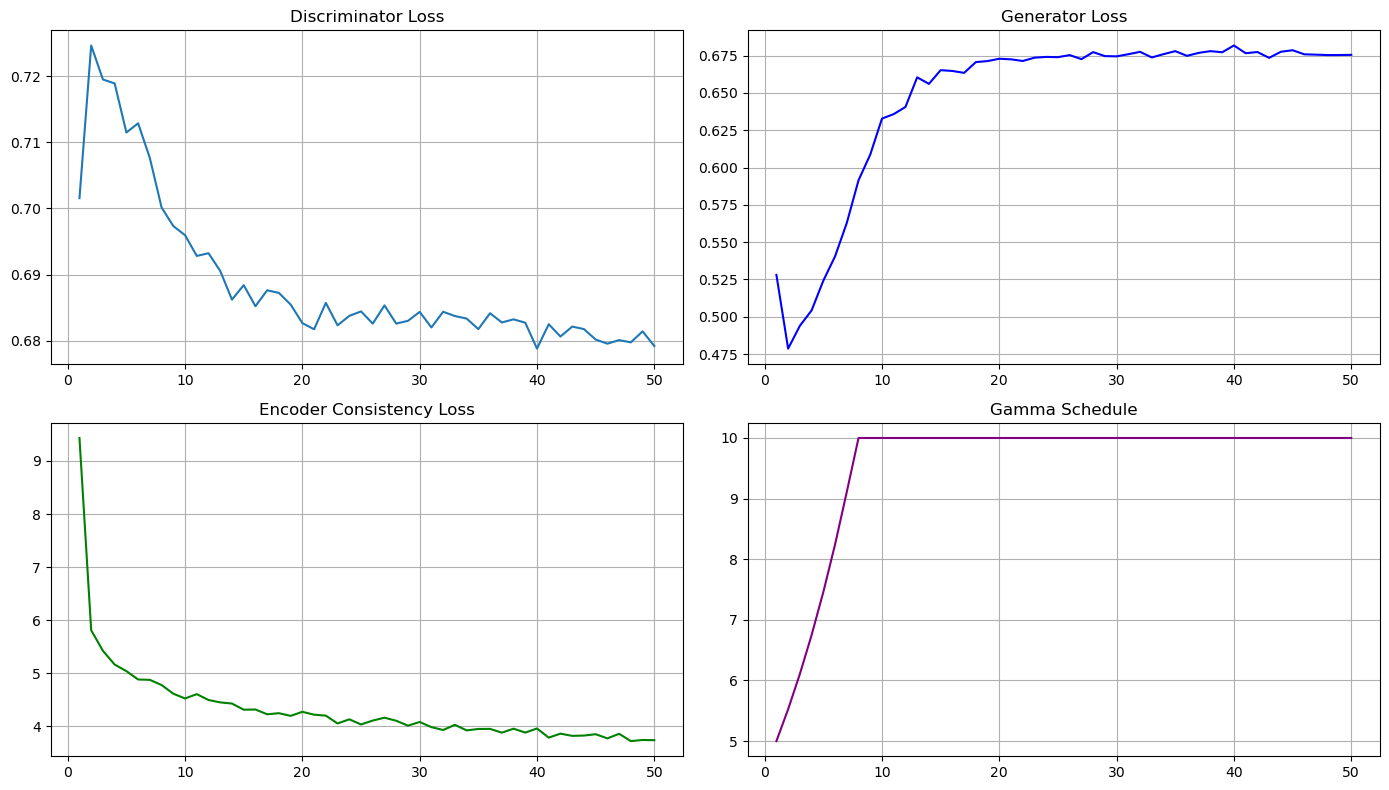

In [61]:
import mlflow
from mlflow.tracking import MlflowClient
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Load experiment and get last run
# -------------------------------------------------------
exp = mlflow.get_experiment_by_name("BiCOGAN-v2")
client = MlflowClient()

runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])
# get latest run
run_id = runs.sort_values("start_time", ascending=False).iloc[0]["run_id"]

print("Using run:", run_id)

# -------------------------------------------------------
# 2. Pull metric histories from MLflow
# -------------------------------------------------------
metric_keys = ["fwdloss", "bwdloss", "efl_loss", "discloss", "gamma"]

metric_hist = {}
for key in metric_keys:
    metric_hist[key] = client.get_metric_history(run_id, key)

# -------------------------------------------------------
# 3. Convert to simple lists
# -------------------------------------------------------
history_raw = {
    "fwd":   [m.value for m in metric_hist["fwdloss"]],
    "bwd":   [m.value for m in metric_hist["bwdloss"]],
    "EFL":   [m.value for m in metric_hist["efl_loss"]],
    "D":     [m.value for m in metric_hist["discloss"]],
    "Gamma": [m.value for m in metric_hist["gamma"]]
}

# -------------------------------------------------------
# 4. Determine batches-per-epoch from training metadata
# -------------------------------------------------------
# If you logged batch_efl_loss once per epoch, we can infer epochs:
epoch_count = len([m.value for m in client.get_metric_history(run_id, "batch_efl_loss")])

steps_total = len(history_raw["fwd"])
batches_per_epoch = steps_total // epoch_count

print("Epochs:", epoch_count)
print("Batches per epoch:", batches_per_epoch)

def group_by_epoch(metric_list, bpe):
    return [
        np.mean(metric_list[i*bpe:(i+1)*bpe])
        for i in range(len(metric_list) // bpe)
    ]

# -------------------------------------------------------
# 5. Build history dict compatible with your plotter
# -------------------------------------------------------
history = {
    "D":     group_by_epoch(history_raw["D"], batches_per_epoch),
    "Adv":   group_by_epoch(history_raw["fwd"], batches_per_epoch),  # generator loss
    "EFL":   group_by_epoch(history_raw["EFL"], batches_per_epoch),
    "Gamma": group_by_epoch(history_raw["Gamma"], batches_per_epoch)
}

# -------------------------------------------------------
# 6. Plot nicely
# -------------------------------------------------------
epochs = np.arange(1, len(history["D"]) + 1)

plt.figure(figsize=(14,8))

# 1. Discriminator Loss
plt.subplot(2,2,1)
plt.plot(epochs, history["D"], label="D-loss")
plt.grid(True); plt.title("Discriminator Loss")

# 2. Generator Adv Loss
plt.subplot(2,2,2)
plt.plot(epochs, history["Adv"], label="Adv-loss (G)", color="blue")
plt.grid(True); plt.title("Generator Loss")

# 3. Encoder Forward Loss
plt.subplot(2,2,3)
plt.plot(epochs, history["EFL"], label="EFL Loss", color="green")
plt.grid(True); plt.title("Encoder Consistency Loss")

# 4. Gamma schedule
plt.subplot(2,2,4)
plt.plot(epochs, history["Gamma"], label="Gamma", color="purple")
plt.grid(True); plt.title("Gamma Schedule")

plt.tight_layout()
plt.show()


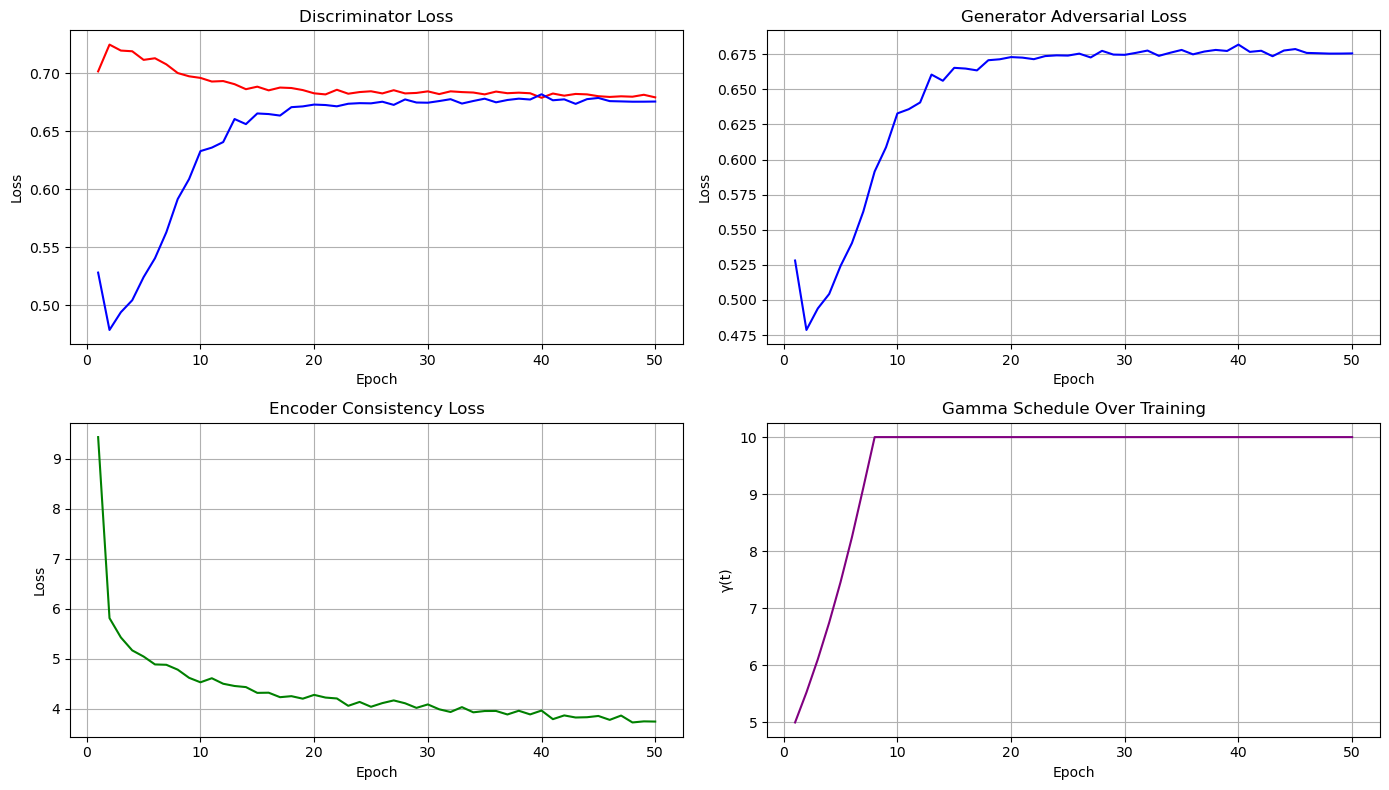

In [62]:
# After building 'history' dict
from ctrl_utilities import evaluate_policy,plot_losses
class FakeTrainer:
    pass

trainer = FakeTrainer()
trainer.history = history

plot_losses(trainer)


In [66]:
from math import log
import torch.nn.functional as F

LOG2PI = float(np.log(2.0 * np.pi))


# ===============================================================
# 1. Base-S Model (State + Reward Gaussian World Model)
# ===============================================================
class BaseS(nn.Module):
    def __init__(self, state_dim: int, num_actions: int, hidden: int = 128):
        super().__init__()
        self.state_dim = state_dim
        self.num_actions = num_actions
        
        # state (8) + action one-hot (4)
        in_dim = state_dim + num_actions
        out_dim = 2 * (state_dim + 1)   # mu/logvar for next-state + reward

        self.fc1 = nn.utils.weight_norm(nn.Linear(in_dim, hidden))
        self.fc2 = nn.utils.weight_norm(nn.Linear(hidden, hidden))
        self.fc3 = nn.utils.weight_norm(nn.Linear(hidden, hidden))
        self.fc4 = nn.Linear(hidden, out_dim)

        for m in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, s: torch.Tensor, a: torch.Tensor):
        """
        Handles both:
          a = (B,)       → integer actions   → convert to one-hot
          a = (B,4)      → already one-hot  → use directly
        """
        # Case 1: Already one-hot
        if a.dim() == 2 and a.size(1) == self.num_actions:
            a_oh = a.float()

        # Case 2: scalar actions → convert to one-hot
        else:
            if a.dim() == 2:
                a = a.squeeze(-1)
            a_oh = F.one_hot(a.long(), num_classes=self.num_actions).float()

        sa = torch.cat([s, a_oh], dim=-1)  # (B, 8+4 = 12)

        h = F.relu(self.fc1(sa))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        out = self.fc4(h)

        mu, logvar = out.chunk(2, dim=-1)

        mu_s     = mu[..., :self.state_dim]
        mu_r     = mu[..., self.state_dim:].unsqueeze(-1)

        logvar_s = logvar[..., :self.state_dim]
        logvar_r = logvar[..., self.state_dim:].unsqueeze(-1)

        return mu_s, mu_r, logvar_s, logvar_r

    def sample_next(self, s, a):
        mu_s, mu_r, logvar_s, logvar_r = self.forward(s, a)

        logvar_s = torch.clamp(logvar_s, -5.0, 5.0)
        logvar_r = torch.clamp(logvar_r, -5.0, 5.0)

        eps_s = torch.randn_like(mu_s)
        eps_r = torch.randn_like(mu_r)

        s_next = mu_s + torch.exp(0.5 * logvar_s) * eps_s
        r_next = mu_r + torch.exp(0.5 * logvar_r) * eps_r

        return s_next, r_next



# ===============================================================
# 2. Gaussian Negative Log-Likelihood Loss
# ===============================================================
def gaussian_nll(x, mu, logvar):
    return 0.5 * (LOG2PI + logvar + (x - mu)**2 / torch.exp(logvar))


# ===============================================================
# 3. Train Base-S Model
# ===============================================================
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_base_s(loader, state_dim, num_actions, epochs=20, lr=1e-3):
    mlflow.set_experiment("BaseS-LunarLander-v3")

    model = BaseS(state_dim, num_actions).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    with mlflow.start_run(description="Base-S World Model Training"):
        mlflow.log_param("state_dim", state_dim)
        mlflow.log_param("num_actions", num_actions)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("lr", lr)

        pbar = tqdm(range(epochs), desc="Training Base-S")

        for epoch in pbar:
            epoch_loss = 0.0
            
            for batch in loader:
                s, a, r, s_next, done = batch

                s       = s.to(device).float()
                a       = a.to(device)         # shape (B,4) one-hot or (B,) int
                r       = r.to(device).float().unsqueeze(-1)
                s_next  = s_next.to(device).float()

                mu_s, mu_r, logvar_s, logvar_r = model(s, a)

                nll_s = gaussian_nll(s_next, mu_s, logvar_s).sum(dim=-1)
                nll_r = gaussian_nll(r, mu_r, logvar_r).squeeze(-1)

                loss = (nll_s + nll_r).mean()

                optim.zero_grad()
                loss.backward()
                optim.step()

                epoch_loss += loss.item()

            epoch_loss /= len(loader)
            loss_history.append(epoch_loss)

            mlflow.log_metric("nll_epoch", epoch_loss, step=epoch)

            pbar.set_postfix({"NLL": f"{epoch_loss:.4f}"})

    return model, loss_history



In [67]:
s, a, r, s_next, done = next(iter(loader))

print("s shape      =", s.shape)
print("a shape      =", a.shape)
print("r shape      =", r.shape)
print("s_next shape =", s_next.shape)
print("done shape   =", done.shape)


s shape      = torch.Size([128, 8])
a shape      = torch.Size([128, 4])
r shape      = torch.Size([128, 1])
s_next shape = torch.Size([128, 8])
done shape   = torch.Size([128, 1])


In [68]:
base_s,loss_history, = train_base_s(
    loader,
    state_dim=obsdim,        # 8
    num_actions=actiondim,   # 4
    epochs=50,               # or 50
    lr=1e-4
)



Training Base-S: 100%|█████████████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it, NLL=-21.0877]


Using run: 6267dc50d1404d7f992552a021b5cd46


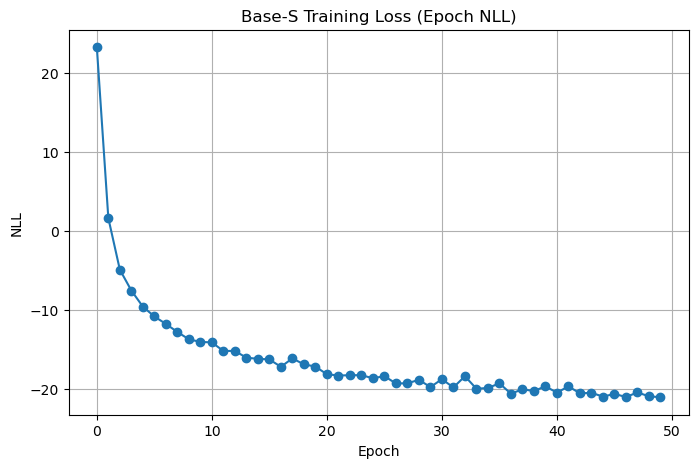

In [69]:
def plot_base_s_loss():
    # Load experiment
    exp = mlflow.get_experiment_by_name("BaseS-LunarLander-v3")
    client = MlflowClient()

    # Get latest run
    runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    run_id = runs.sort_values("start_time", ascending=False).iloc[0]["run_id"]

    print("Using run:", run_id)

    # Pull metric history
    metric_history = client.get_metric_history(run_id, "nll_epoch")

    # Extract (step, value) pairs
    steps  = [m.step for m in metric_history]
    values = [m.value for m in metric_history]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(steps, values, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    plt.title("Base-S Training Loss (Epoch NLL)")
    plt.grid(True)
    plt.show()
plot_base_s_loss()

In [70]:
base_s

BaseS(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=18, bias=True)
)

In [71]:
# %% GENERATE BASE-S COUNTERFACTUAL TRANSITIONS
# base_s is already trained

def generate_cf_base_s(model, transitions, num_actions=4):
    cf_data = []

    for (s, a_real, r, s_next, done) in transitions:
        s_t = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)

        for a_cf in range(num_actions):
            if a_cf == a_real:
                continue

            a_t = torch.tensor([a_cf]).long().to(device)

            with torch.no_grad():
                mu_s, mu_r, logvar_s, logvar_r = model(s_t, a_t)
                s_hat = mu_s.squeeze(0).cpu().numpy()
                r_hat = mu_r.item()
                done_hat = False  # Base-S cannot predict done

            cf_data.append([s, a_cf, r_hat, s_hat, done_hat])

    return cf_data

print("Generating Base-S CF...")
cf_base_s = generate_cf_base_s(base_s, traindata, num_actions=actiondim)
print("Base-S CF samples:", len(cf_base_s))


Generating Base-S CF...
Base-S CF samples: 141186


In [72]:
# %% GENERATE BICOGAN COUNTERFACTUAL TRANSITIONS

def generate_cf_bicogan(bicogan, transitions, num_actions=4):
    cf_data = []

    for (s, a_real, r, s_next, done) in transitions:

        # prepare tensors
        s_t       = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
        s_next_t  = torch.tensor(s_next, dtype=torch.float32).unsqueeze(0).to(device)
        r_t       = torch.tensor([r], dtype=torch.float32).unsqueeze(0).to(device)

        # Step 1: invert the forward pass → get latent u_hat
        with torch.no_grad():
            _, _, u_hat = bicogan.backward(s_next_t, r_t)

        # Step 2: generate CF for all alternative actions
        for a_cf in range(num_actions):
            if a_cf == a_real:
                continue   # skip the real action

            a_onehot = F.one_hot(torch.tensor(a_cf), num_actions)\
                         .float().unsqueeze(0).to(device)

            # forward pass with replaced action + same u_hat
            with torch.no_grad():
                s_hat, done_hat, r_hat = bicogan.forward(s_t, a_onehot, u_hat)

            cf_data.append([
                s,                                           # state
                a_cf,                                        # CF action
                float(r_hat.item()),                         # CF reward
                s_hat.squeeze(0).cpu().numpy(),              # CF next_state
                bool(done_hat.item() > 0)                    # CF termination
            ])

    return cf_data


print("Generating BiCoGAN CF...")
cf_bicogan = generate_cf_bicogan(bicogan, traindata, num_actions=actiondim)
print("BiCoGAN CF samples:", len(cf_bicogan))


Generating BiCoGAN CF...
BiCoGAN CF samples: 141186


### “In this setup, we use counterfactual samples generated by both Base-S and BiCoGAN from previously stored transitions, and train the D3QN agent using this combined CF buffer.”

In [ ]:
from ctrl_data import ReplayBuffer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import mlflow

device = "cuda" if torch.cuda.is_available() else "cpu"


# ===============================================================
# Dueling DQN network (unchanged, correct)
# ===============================================================
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=-1, keepdim=True))
        return q_values



# ===============================================================
# Default D3QN hyperparameters
# ===============================================================
class D3QNParams:
    eps_start = 1.0
    eps_end = 0.01
    eps_decay = 300
    lr = 5e-4
    min_buffer = 256
    batch_size = 128
    gamma = 0.99
    max_episodes = 200
    max_iter = 1000
    tau = 0.005
    optimizer = torch.optim.Adam
    criteria = torch.nn.MSELoss
    mix_ratio = 0.5   # 50% REAL + 50% CF during offline mixing



# ===============================================================
# Patched D3QNAgent
# ===============================================================
class D3QNAgent:

    def __init__(self, env, policy_net, target_net, scm=None):
        self.env = env
        self.policy_net = policy_net.to(device)
        self.target_net = target_net.to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.hparams = D3QNParams()
        self.optimizer = self.hparams.optimizer(
            self.policy_net.parameters(), lr=self.hparams.lr
        )

        # --------------------------------------------
        # ❗ Most important fix: correct number of actions
        # --------------------------------------------
        self.actiondim = env.action_space.n

        # --------------------------------------------
        # Replay buffers
        # --------------------------------------------
        self.ReplayMem = ReplayBuffer(
            max_size=100000,
            state_dim=env.observation_space.shape[0],
            action_dim=1,
            batch_size=self.hparams.batch_size
        )

        self.Counterfactual = ReplayBuffer(
            max_size=500000,
            state_dim=env.observation_space.shape[0],
            action_dim=1,
            batch_size=self.hparams.batch_size
        )

        self.global_steps = 0
        self.learn_steps = 0
        self.eps_threshold = self.hparams.eps_start

        self.scm = scm   # Base-S or BiCoGAN (optional)
        self.scm_specified = scm is not None



    # ===============================================================
    # Update target network (soft update)
    # ===============================================================
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.hparams.tau

        for tgt, src in zip(self.target_net.parameters(), self.policy_net.parameters()):
            tgt.data.copy_((1 - tau) * tgt + tau * src)



    # ===============================================================
    # Epsilon schedule
    # ===============================================================
    def decrement_epsilon(self):
        eps_start, eps_end, decay = (
            self.hparams.eps_start, self.hparams.eps_end, self.hparams.eps_decay
        )
        self.eps_threshold = eps_end + (eps_start - eps_end) * \
                             np.exp(-1.0 * self.global_steps / decay)



    # ===============================================================
    # The fully corrected hybrid training function
    # ===============================================================
    def TrainFromReplayMem(
            self,
            replay='replay',      # 'replay', 'counterfactual', 'offline'
            mix=False,
            batch_size=None):

        DEFAULT_LOSS = 0.0
        if batch_size is None:
            batch_size = self.hparams.batch_size

        # Mixing ratio for hybrid CTRL training
        mix_ratio = self.hparams.mix_ratio
        k_cf   = int(batch_size * mix_ratio)
        k_real = batch_size - k_cf

        # ------------------------------------------
        # Real-only
        # ------------------------------------------
        if replay == 'replay':
            if not self.ReplayMem.ready():
                return DEFAULT_LOSS
            batch = self.ReplayMem.sample_buffer()
            states, actions, rewards, next_states, terminals = batch

        # ------------------------------------------
        # CF-only
        # ------------------------------------------
        elif replay == 'counterfactual':
            if not self.Counterfactual.ready():
                return DEFAULT_LOSS
            batch = self.Counterfactual.sample_buffer()
            states, actions, rewards, next_states, terminals = batch

        # ------------------------------------------
        # Hybrid CTRL (REAL + CF mix)
        # ------------------------------------------
        elif replay == 'offline':
            if not self.ReplayMem.ready():
                return DEFAULT_LOSS
            if self.Counterfactual.mem_cnt < k_cf:
                return DEFAULT_LOSS

            states_real, actions_real, rewards_real, next_real, terms_real = \
                self.ReplayMem.sample_buffer(batch_size=k_real)

            states_cf, actions_cf, rewards_cf, next_cf, terms_cf = \
                self.Counterfactual.sample_buffer(batch_size=k_cf)

            states      = np.concatenate([states_real,  states_cf], axis=0)
            actions     = np.concatenate([actions_real, actions_cf], axis=0)
            rewards     = np.concatenate([rewards_real, rewards_cf], axis=0)
            next_states = np.concatenate([next_real,   next_cf],   axis=0)
            terminals   = np.concatenate([terms_real,  terms_cf],  axis=0)
        else:
            raise ValueError(f"Unknown replay={replay}")

        # Convert to tensors
        states      = torch.tensor(states, dtype=torch.float32, device=device)
        actions     = torch.tensor(actions, dtype=torch.long,   device=device).view(-1)
        rewards     = torch.tensor(rewards, dtype=torch.float32, device=device).view(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
        terminals   = torch.tensor(terminals, dtype=torch.float32, device=device).view(-1)

        # ---------------------------------
        # Double-DQN target
        # ---------------------------------
        with torch.no_grad():
            next_q_eval = self.policy_net(next_states)
            best_actions = next_q_eval.argmax(dim=1)

            next_q_target = self.target_net(next_states)
            next_vals = next_q_target.gather(1, best_actions.unsqueeze(1)).squeeze(1)

            target = rewards + self.hparams.gamma * (1 - terminals) * next_vals

        # ---------------------------------
        # Q(s,a)
        # ---------------------------------
        q_pred = self.policy_net(states)
        q_taken = q_pred.gather(1, actions.unsqueeze(1)).squeeze(1)

        # ---------------------------------
        # Loss
        # ---------------------------------
        loss = F.smooth_l1_loss(q_taken, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_steps += 1
        self.update_network_parameters()

        return float(loss.item())



    # ===============================================================
    # Rollout on real environment
    # ===============================================================
    def RolloutTrajectory(self, num_episodes=10):
        self.policy_net.eval()
        rewards = []

        for _ in range(num_episodes):
            obs, _ = self.env.reset()
            terminated = truncated = False
            total_r = 0

            while not (terminated or truncated):
                obs_t = torch.tensor(obs, dtype=torch.float32, device=device)
                with torch.no_grad():
                    a = self.policy_net(obs_t).argmax().item()

                obs, r, terminated, truncated, _ = self.env.step(a)
                total_r += r

            rewards.append(total_r)

        return rewards



    # ===============================================================
    # Episode loop (collect real experience)
    # ===============================================================
    def ElapseOneEpisode(self, useCfData=False):

        obs, _ = self.env.reset()
        epreward = 0
        terminated = truncated = False

        losses = []

        while not (terminated or truncated):

            self.decrement_epsilon()

            # ε-greedy
            if np.random.rand() < self.eps_threshold:
                action = self.env.action_space.sample()
            else:
                obs_t = torch.tensor(obs, dtype=torch.float32, device=device)
                with torch.no_grad():
                    action = self.policy_net(obs_t).argmax().item()

            next_obs, reward, terminated, truncated, _ = self.env.step(action)

            self.ReplayMem.store_transition(obs, action, reward, next_obs, terminated)

            self.global_steps += 1
            epreward += reward
            obs = next_obs

            # Train
            if useCfData:
                loss = self.TrainFromReplayMem(replay='offline')
            else:
                loss = self.TrainFromReplayMem(replay='replay')

            if loss != 0.0:
                losses.append(loss)

        return epreward, np.mean(losses) if losses else 0.0



    # ===============================================================
    # FULL TRAINING LOOP
    # ===============================================================
    def train(self, useCfData=False):

        # -------------------------------
        # Warm-up phase
        # -------------------------------
        warmup_steps = 300
        for _ in range(warmup_steps):
            if useCfData:
                self.TrainFromReplayMem(replay='offline')
            else:
                self.TrainFromReplayMem(replay='replay')

        # -------------------------------
        # Main phase
        # -------------------------------
        rewards = []
        for ep in tqdm(range(self.hparams.max_episodes)):

            r, loss = self.ElapseOneEpisode(useCfData=useCfData)
            rewards.append(r)

            mlflow.log_metric("Reward", r, step=self.global_steps)
            mlflow.log_metric("Loss", loss,   step=self.global_steps)

        return rewards


def apply_dqn_overrides(agent, overrides: dict):
    """Apply your custom dqnParams to the agent's hparams."""
    for k, v in overrides.items():
        if hasattr(agent.hparams, k):
            setattr(agent.hparams, k, v)


def prepare_buffer(agent, real_data, cf_data=None):
    """
    Populate an agent's ReplayMem (real data) and Counterfactual (optional).
    real_data, cf_data: lists of [s, a, r, s_next, done]
    """
    state_dim = agent.env.observation_space.shape[0]

    # ----------------------------
    # Real Replay Buffer
    # ----------------------------
    agent.ReplayMem = ReplayBuffer(
        max_size=100000,
        state_dim=state_dim,
        action_dim=1,                         # scalar action index
        batch_size=agent.hparams.batch_size
    )

    for (s, a, r, s_next, done) in real_data:
        agent.ReplayMem.store_transition(s, a, r, s_next, done)

    # ----------------------------
    # Counterfactual Buffer
    # ----------------------------
    if cf_data is not None:
        agent.Counterfactual = ReplayBuffer(
            max_size=500000,
            state_dim=state_dim,
            action_dim=1,
            batch_size=agent.hparams.batch_size
        )
        for (s, a, r, s_next, done) in cf_data:
            agent.Counterfactual.store_transition(s, a, r, s_next, done)


def run_experiment(name, agent, use_cf: bool):
    """
    Train the agent and evaluate on the real env.
    use_cf=False → Real-only training
    use_cf=True  → Hybrid CTRL (real + CF mixing)
    """
    print(f"\n========== {name} ==========")

    # Train the agent
    agent.train(useCfData=use_cf)

    # Evaluate on real env
    eval_returns = agent.RolloutTrajectory(num_episodes=10)
    mean_ret = np.mean(eval_returns)
    std_ret = np.std(eval_returns)

    print(f"[{name}] Eval returns: {eval_returns}")
    print(f"[{name}] Mean = {mean_ret:.2f}, Std = {std_ret:.2f}")

    return mean_ret, std_ret


In [114]:
# =====================================================
# 0. Convert traindata → numpy transitions
# =====================================================

real_data = []
for s, a, r, s_next, done in traindata:

    # a is ALREADY scalar int (0..3) in your dataset
    a_idx = int(a)

    real_data.append([
        s.astype(np.float32),
        a_idx,
        float(r),
        s_next.astype(np.float32),
        bool(done)
    ])

print("Real transitions:", len(real_data))



# =====================================================
# 1. Agent Hyperparameters
# =====================================================

tgtEnv   = env
obs_dim  = obsdim      # 8
act_dim  = actiondim   # 4

dqnParams = {
    "min_buffer":   256,
    "batch_size":   256,
    "lr":           5e-4,
    "tau":          0.001,
    "max_iter":     1000,
    "eps_start":    1.0,
    "eps_end":      0.01,
    "max_episodes": 50
}


# =====================================================
# 2. Create three agents
# =====================================================

agent_real = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),      # actiondim=4
    DuelingDQN(obs_dim, act_dim)
)
apply_dqn_overrides(agent_real, dqnParams)

agent_base_s = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim)
)
apply_dqn_overrides(agent_base_s, dqnParams)

agent_bicogan = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim)
)
apply_dqn_overrides(agent_bicogan, dqnParams)



# =====================================================
# 3. Fill Buffers
# =====================================================

prepare_buffer(agent_real, real_data, cf_data=None)
prepare_buffer(agent_base_s, real_data, cf_data=cf_base_s)
prepare_buffer(agent_bicogan, real_data, cf_data=cf_bicogan)


Real transitions: 47062


In [115]:
mean_real, std_real = run_experiment("Real Only", agent_real, use_cf=False)



========== Real Only ==========


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:02<00:00,  2.45s/it]


[Real Only] Eval returns: [-41.85250359657477, 8.137275036829307, -28.78263244478804, -46.448018621752965, 96.3049618326196, -37.4313531596586, -71.35196958532521, -66.94594592235777, -73.24738707595348, -37.87506734425104]
[Real Only] Mean = -29.95, Std = 47.84


In [118]:
mean_base_s, std_base_s = run_experiment("Real + Base-S CF", agent_base_s, use_cf=True)



========== Real + Base-S CF ==========


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]

[Real + Base-S CF] Eval returns: [20.396421589891112, -213.6993834655533, -57.05859902129478, -381.61120379919123, -212.4600222330521, 172.2558848420001, -30.48652753992053, -57.293087721764735, -209.39727698486465, 12.596158425041423]
[Real + Base-S CF] Mean = -95.68, Std = 150.48


In [122]:
mean_bicogan, std_bicogan = run_experiment("Real + BiCoGAN CF", agent_bicogan, use_cf=True)



========== Real + BiCoGAN CF ==========


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]

[Real + BiCoGAN CF] Eval returns: [27.906098580242926, -53.25468911230733, -6.67551692074619, 204.18040473731935, -162.13550759977247, -163.35593594319553, 14.147390718567877, 11.185126788824448, -11.752284740292751, -95.28589513352135]
[Real + BiCoGAN CF] Mean = -23.50, Std = 101.16


## 📌 Counterfactual Selection Logic (Base-S and BiCoGAN SCM)-BellMan Score

In this experiment, we interact with the environment normally and, for every
real transition $ (s_t, a_t, r_t, s_{t+1}) $, we generate *counterfactual*
next-states using either:

- the **Base-S Gaussian world model**, or  
- the **BiCoGAN structural causal model (SCM)**.

Both models can propose alternative next-states for actions *different* from
the one actually taken.

### 🔍 How the "best" counterfactual is chosen

For each candidate counterfactual action $ a_{\text{cf}} \neq a_t $:

1. We pass the current state into the SCM with action $ a_{\text{cf}} $.

2. The SCM predicts:
   - a counterfactual next state $ \hat{s}' $
   - a counterfactual reward $ \hat{r} $
   - (BiCoGAN only) a predicted termination flag $ \hat{d} $.

3. For each counterfactual next-state, we compute a **Bellman score**:

$$
B_i = \hat{r}_i \;+\; \gamma \; (1 - \hat{d}_i)\; 
\max_{a'} Q_{\text{target}}(\hat{s}'_i, a')
$$

4. The counterfactual with the **highest Bellman score** is selected:

$$
(a_{\text{best}},\; \hat{s}'_{\text{best}},\; B_{\text{best}})
$$

### ✔ What gets stored

Only **one** CF transition is added to the counterfactual buffer, containing:

- the original state $s_t$
- the selected counterfactual action $a_{\text{best}}$
- the CF reward $ \hat{r}_{\text{best}} $
- the CF next state $ \hat{s}'_{\text{best}} $
- the CF termination flag $ \hat{d}_{\text{best}} $


In [135]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import gymnasium as gym
from ctrl_data import ReplayBuffer

device = "cuda" if torch.cuda.is_available() else "cpu"

# =====================================================
# 1. Dueling DQN network
# =====================================================

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=-1, keepdim=True))
        return q_values


# =====================================================
# 2. Hyperparameters
# =====================================================

class D3QNParams:
    eps_start = 0.9
    eps_end   = 0.05
    eps_decay = 200
    lr        = 5e-4
    min_buffer = 256
    batch_size = 64
    gamma      = 0.99
    reward_min = -500
    reward_max = 500
    max_episodes = 100
    max_iter     = 1000
    update_tgt_nw_ep = 50
    criteria = torch.nn.MSELoss
    optimizer = torch.optim.Adam
    decay_steps = 1e8
    tau = 0.005
    mix_ratio = 0.5


# =====================================================
# 3. D3QN Agent (Fully Updated with Bellman CF)
# =====================================================

class D3QNAgent:
    def __init__(self, env: gym.Env,
                 policy_net: nn.Module,
                 target_net: nn.Module,
                 scm=None,
                 scm_type=None,   # None, "base_s", "bicogan"
                 **kwargs):

        self.SetHP()

        self.env        = env
        self.policy_net = policy_net.to(device)
        self.target_net = target_net.to(device)

        self.optimizer = self.hparams.optimizer(
            self.policy_net.parameters(),
            lr=self.hparams.lr
        )

        self.target_net.eval()
        self.policy_net.train()

        self.update_network_parameters(tau=1.0)
        self.criteria = self.hparams.criteria()

        # action dim
        if isinstance(env.action_space, gym.spaces.Discrete):
            actiondim = 1
            self.num_actions = env.action_space.n
        else:
            actiondim = env.action_space.shape[0]
            self.num_actions = actiondim

        self.ReplayMem = ReplayBuffer(
            max_size=100000,
            state_dim=self.env.observation_space.shape[0],
            action_dim=actiondim,
            batch_size=self.hparams.batch_size
        )
        self.Counterfactual = ReplayBuffer(
            max_size=400000,
            state_dim=self.env.observation_space.shape[0],
            action_dim=actiondim,
            batch_size=self.hparams.batch_size
        )

        self.global_steps = 0
        self.learn_steps  = 0
        self.history      = []

        self.scm      = scm
        self.scm_type = scm_type

        self.eps_threshold = self.hparams.eps_start


    def SetHP(self):
        self.hparams = D3QNParams()


    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.hparams.tau
        for q_target, q_eval in zip(self.target_net.parameters(),
                                    self.policy_net.parameters()):
            q_target.data.copy_(
                (1 - tau) * q_target.data + tau * q_eval.data
            )


    def decrement_epsilon(self):
        eps_start = self.hparams.eps_start
        eps_end   = self.hparams.eps_end
        t         = self.global_steps
        eps_decay = self.hparams.eps_decay
        self.eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-t / eps_decay)


    # =================================================
    # 3.1 Bellman CF scoring (NEW)
    # =================================================
    def _select_best_cf_bellman(self, cf_candidates):
        """
        cf_candidates: list of dicts:
            {
                'a_cf': int,
                's_hat': np.array,
                'r_hat': float,
                'done_hat': bool
            }
        Returns best candidate using:
            Bellman = r_hat + gamma * max_a' Q_target(s_hat,a')
        """

        best_score = -1e15
        best_cand  = None

        for cand in cf_candidates:
            s_hat_tensor = torch.tensor(
                cand['s_hat'], dtype=torch.float32, device=device
            ).unsqueeze(0)

            with torch.no_grad():
                q_next = self.target_net(s_hat_tensor).max(dim=1)[0].item()

            bellman = cand['r_hat'] + \
                       self.hparams.gamma * (1.0 - float(cand['done_hat'])) * q_next

            if bellman > best_score:
                best_score = bellman
                best_cand  = cand

        return best_cand


    # =================================================
    # 3.2 Base-S Bellman CF selection
    # =================================================
    def _add_best_cf_base_s(self, state_np, action_real):
        if self.scm is None:
            return

        s_t = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)

        cf_candidates = []

        for a_cf in range(self.num_actions):
            if a_cf == action_real:
                continue

            a_t = torch.tensor([a_cf], dtype=torch.long, device=device)

            with torch.no_grad():
                mu_s, mu_r, _, _ = self.scm(s_t, a_t)

            cf_candidates.append({
                'a_cf': a_cf,
                's_hat': mu_s.squeeze(0).cpu().numpy(),
                'r_hat': float(mu_r.item()),
                'done_hat': False
            })

        best_cf = self._select_best_cf_bellman(cf_candidates)

        self.Counterfactual.store_transition(
            state_np,
            best_cf['a_cf'],
            best_cf['r_hat'],
            best_cf['s_hat'],
            best_cf['done_hat']
        )


    # =================================================
    # 3.3 BiCoGAN Bellman CF selection
    # =================================================
    def _add_best_cf_bicogan(self, state_np, action_real, reward_real, next_state_np):
        if self.scm is None:
            return

        s_t      = torch.tensor(state_np,      dtype=torch.float32, device=device).unsqueeze(0)
        s_next_t = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)
        r_t      = torch.tensor([[reward_real]], dtype=torch.float32, device=device)

        # infer u_hat from real transition
        with torch.no_grad():
            _, _, u_hat = self.scm.backward(s_next_t, r_t)

        cf_candidates = []

        for a_cf in range(self.num_actions):
            if a_cf == action_real:
                continue

            a_onehot = F.one_hot(
                torch.tensor(a_cf, device=device),
                self.num_actions
            ).float().unsqueeze(0)

            with torch.no_grad():
                s_hat, done_hat, r_hat = self.scm.forward(s_t, a_onehot, u_hat)

            cf_candidates.append({
                'a_cf': a_cf,
                's_hat': s_hat.squeeze(0).cpu().numpy(),
                'r_hat': float(r_hat.item()),
                'done_hat': bool(done_hat.item() > 0)
            })

        best_cf = self._select_best_cf_bellman(cf_candidates)

        self.Counterfactual.store_transition(
            state_np,
            best_cf['a_cf'],
            best_cf['r_hat'],
            best_cf['s_hat'],
            best_cf['done_hat']
        )


    # =================================================
    # 3.4 Replay Training (unchanged)
    # =================================================
    def TrainFromReplayMem(self,
                           replay='replay',
                           batch_size=None,
                           **kwargs):

        DEFAULT_LOSS = 0.0

        if batch_size is None:
            batch_size = self.hparams.batch_size

        mix_ratio = self.hparams.mix_ratio
        k_cf   = int(batch_size * mix_ratio)
        k_real = batch_size - k_cf

        if replay == 'replay':
            if not self.ReplayMem.ready(): return DEFAULT_LOSS
            states, actions, rewards, next_states, terminals = \
                self.ReplayMem.sample_buffer()

        elif replay == 'counterfactual':
            if not self.Counterfactual.ready(): return DEFAULT_LOSS
            states, actions, rewards, next_states, terminals = \
                self.Counterfactual.sample_buffer()

        elif replay == 'offline':
            if not self.ReplayMem.ready(): return DEFAULT_LOSS
            if self.Counterfactual.mem_cnt < k_cf: return DEFAULT_LOSS

            states_real, actions_real, rewards_real, next_real, terms_real = \
                self.ReplayMem.sample_buffer(batch_size=k_real)

            states_cf, actions_cf, rewards_cf, next_cf, terms_cf = \
                self.Counterfactual.sample_buffer(batch_size=k_cf)

            states      = np.concatenate([states_real, states_cf], axis=0)
            actions     = np.concatenate([actions_real, actions_cf], axis=0)
            rewards     = np.concatenate([rewards_real, rewards_cf], axis=0)
            next_states = np.concatenate([next_real,  next_cf],   axis=0)
            terminals   = np.concatenate([terms_real, terms_cf],  axis=0)

        else:
            raise ValueError(f"Unknown replay mode: {replay}")

        states_tensor      = torch.tensor(states, dtype=torch.float32, device=device)
        actions_tensor     = torch.tensor(actions, dtype=torch.long, device=device).view(-1)
        rewards_tensor     = torch.tensor(rewards, dtype=torch.float32, device=device).view(-1)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)
        terminals_tensor   = torch.tensor(terminals, dtype=torch.float32, device=device).view(-1)

        # Double DQN target
        with torch.no_grad():
            q_eval_next  = self.policy_net(next_states_tensor)
            best_actions = q_eval_next.argmax(dim=1)
            q_tgt_next   = self.target_net(next_states_tensor)
            next_vals    = q_tgt_next.gather(1, best_actions.unsqueeze(1)).squeeze(1)

            target = rewards_tensor + self.hparams.gamma * (1 - terminals_tensor) * next_vals

        # Q(s,a)
        q_pred_all = self.policy_net(states_tensor)
        q_taken    = q_pred_all.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

        loss = F.smooth_l1_loss(q_taken, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_steps += 1
        self.update_network_parameters()

        return float(loss.item())


    # =================================================
    # 3.5 Rollout + Training Loops
    # =================================================
    def RolloutTrajectory(self, num_episodes=20):
        self.policy_net.eval()
        ep_hist = []

        for _ in range(num_episodes):
            obs, _ = self.env.reset()
            done = False
            total = 0

            while not done:
                obs_t = torch.tensor(obs, dtype=torch.float32, device=device)
                with torch.no_grad():
                    qvals = self.policy_net(obs_t)
                a = int(qvals.argmax().item())
                obs, r, terminated, truncated, _ = self.env.step(a)
                done = terminated or truncated
                total += r

            ep_hist.append(total)

        return ep_hist


    def ElapseOneEpisode(self, episode, useCfData=False):
        epreward = 0
        losshist = []
        trun = term = False
        obs, _ = self.env.reset()

        for _ in range(self.hparams.max_iter):

            self.decrement_epsilon()

            # epsilon-greedy
            if np.random.rand() < self.eps_threshold:
                action = int(self.env.action_space.sample())
            else:
                with torch.no_grad():
                    qvals = self.policy_net(torch.tensor(obs, dtype=torch.float32, device=device))
                action = int(qvals.argmax().item())

            next_obs, r, term, trun, _ = self.env.step(action)
            done = term or trun

            self.global_steps += 1
            epreward += r

            self.ReplayMem.store_transition(
                obs.astype(np.float32),
                action,
                float(r),
                next_obs.astype(np.float32),
                done
            )

            # add Bellman CF
            if useCfData and self.scm is not None:
                if self.scm_type == "base_s":
                    self._add_best_cf_base_s(obs.astype(np.float32), action)
                elif self.scm_type == "bicogan":
                    self._add_best_cf_bicogan(
                        obs.astype(np.float32),
                        action,
                        float(r),
                        next_obs.astype(np.float32)
                    )

            obs = next_obs

            # training
            if useCfData and self.scm is not None:
                loss = self.TrainFromReplayMem(replay='offline')
            else:
                loss = self.TrainFromReplayMem(replay='replay')

            if loss != 0:
                losshist.append(loss)

            if done:
                break

        mean_loss = float(np.mean(losshist)) if len(losshist) > 0 else 0.0
        return epreward, len(losshist), mean_loss


    def train(self, useCfData=False):
        rewardhist = []
        self.eps_threshold = self.hparams.eps_start

        tq = tqdm(range(self.hparams.max_episodes))
        for ep in tq:
            r, _, L = self.ElapseOneEpisode(ep, useCfData=useCfData)
            rewardhist.append(r)
            avgR = np.mean(rewardhist[-100:])

            tq.set_postfix({
                "EP": ep,
                "Reward": r,
                "Avg100": avgR,
                "Eps": self.eps_threshold,
                "Loss": L
            })


# =====================================================
# 4. Helpers
# =====================================================

def apply_dqn_overrides(agent, overrides: dict):
    for k, v in overrides.items():
        if hasattr(agent.hparams, k):
            setattr(agent.hparams, k, v)


def run_experiment(name, agent, use_cf: bool):
    print(f"\n========== {name} ==========")
    agent.train(useCfData=use_cf)
    eval_returns = agent.RolloutTrajectory(num_episodes=20)
    mean_ret = float(np.mean(eval_returns))
    std_ret  = float(np.std(eval_returns))
    print(f"[{name}] Eval returns: {eval_returns}")
    print(f"[{name}] Mean = {mean_ret:.2f}, Std = {std_ret:.2f}")
    return mean_ret, std_ret


In [136]:
# =====================================================
# Create env + sizes (if not already done)
# =====================================================
# envName = "LunarLander-v3"
# tgtDom  = Specs(enable_wind=False, turbulence_power=0.0)
# env     = gym.make(envName, **vars(tgtDom))
# obsdim  = env.observation_space.shape[0]
# actiondim = env.action_space.n

tgtEnv   = env
obs_dim  = obsdim
act_dim  = actiondim

# DQN overrides
dqnParams = {
    "min_buffer":   256,
    "batch_size":   256,
    "lr":           5e-4,
    "tau":          0.001,
    "max_iter":     1000,
    "eps_start":    1.0,
    "eps_end":      0.01,
    "max_episodes": 50,   # you can crank to 200 later
    "mix_ratio":    0.5   # 50% CF in hybrid batches
}

# =====================================================
# 1) Real-only agent
# =====================================================
agent_real = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=None,
    scm_type=None
)
apply_dqn_overrides(agent_real, dqnParams)

# =====================================================
# 2) Base-S hybrid agent
# =====================================================
agent_base_s = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=base_s,
    scm_type="base_s"
)
apply_dqn_overrides(agent_base_s, dqnParams)

# =====================================================
# 3) BiCoGAN hybrid agent
# =====================================================
agent_bicogan = D3QNAgent(
    tgtEnv,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=bicogan,
    scm_type="bicogan"
)
apply_dqn_overrides(agent_bicogan, dqnParams)

# =====================================================
# Train + evaluate (this will take some time)
# =====================================================
mean_real,     std_real     = run_experiment("Real Only",           agent_real,     use_cf=False)
mean_base_s,   std_base_s   = run_experiment("Real + Base-S (best CF)", agent_base_s,   use_cf=True)
mean_bicogan,  std_bicogan  = run_experiment("Real + BiCoGAN (best CF)", agent_bicogan, use_cf=True)

print("\n================= FINAL RESULTS (20 eval episodes) =================")
print(f"Real Only:              Mean={mean_real:.2f}, Std={std_real:.2f}")
print(f"Real + Base-S (bestCF): Mean={mean_base_s:.2f}, Std={std_base_s:.2f}")
print(f"Real + BiCoGAN (bestCF):Mean={mean_bicogan:.2f}, Std={std_bicogan:.2f}")



========== Real Only ==========


100%|█████████████████████████████████████████| 50/50 [00:22<00:00,  2.18it/s, EP=49, Reward=-250, Avg100=-123, Eps=0.01, Loss=0.721]


[Real Only] Eval returns: [-122.76602445862746, -80.50771865679171, -229.62944144408877, -149.6822336699587, -110.5936117845836, -178.96986954984368, -253.18140881491777, -213.9318208742468, -121.90996664886782, -64.6220148462819, -100.08285514119923, -167.98847789609337, -116.97080101380229, -253.87859777103606, -203.48623263204894, -121.53711729062293, -104.71332963435042, -109.0306058365573, -110.9166666935925, -104.58593831556706]
[Real Only] Mean = -145.95, Std = 55.89

========== Real + Base-S (best CF) ==========


100%|█████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s, EP=49, Reward=-257, Avg100=-296, Eps=0.01, Loss=0.685]


[Real + Base-S (best CF)] Eval returns: [-462.2654869449439, -279.25538024788045, -452.7195489616071, -226.80521074992413, -317.314389314108, -209.89133879911958, -459.7898588717712, -524.6399957928978, -186.5066451080918, -422.8147340611467, -435.89205857780894, -169.72656804933743, -280.72154131848686, -171.87461541472095, -306.0212517125792, -295.4958062839528, -221.21206718483847, -487.71031561683793, -209.7882750106632, -419.3641604449976]
[Real + Base-S (best CF)] Mean = -326.99, Std = 116.05

========== Real + BiCoGAN (best CF) ==========


100%|██████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s, EP=49, Reward=-190, Avg100=-219, Eps=0.01, Loss=2.17]

[Real + BiCoGAN (best CF)] Eval returns: [-235.833290961278, -316.04090196184427, -297.6428691736561, -338.2177584956844, -249.07834590642665, -216.58151480638082, -355.80971774301366, -152.39870377371415, -97.55562755203884, -58.57358886729654, -285.6171630597247, -345.9310650281652, -130.00229033464095, -323.1548521448624, -323.87229722568657, -283.28019939270786, -241.6226293791774, -333.4175336564732, -322.0988468991379, -342.876508397681]
[Real + BiCoGAN (best CF)] Mean = -262.48, Std = 86.85

================= FINAL RESULTS (20 eval episodes) =================
Real Only:              Mean=-145.95, Std=55.89
Real + Base-S (bestCF): Mean=-326.99, Std=116.05
Real + BiCoGAN (bestCF):Mean=-262.48, Std=86.85


## 📌 Counterfactual Selection Logic (Base-S and BiCoGAN SCM) _max Reward

In this experiment, we interact with the environment normally and, for every
real transition $ (s_t, a_t, r_t, s_{t+1}) $, we generate *counterfactual*
next-states using either:

- the **Base-S Gaussian world model**, or  
- the **BiCoGAN structural causal model (SCM)**.

Both models can propose alternative next-states for actions *different* from
the one actually taken.

### 🔍 How the "best" counterfactual is chosen

For each candidate counterfactual action $ a_{\text{cf}} \neq a_t $:

1. We pass the current state into the SCM with action $ a_{\text{cf}} $.

2. The SCM predicts:
   - a counterfactual next state $ \hat{s}' $
   - a counterfactual reward $ \hat{r} $
   - (BiCoGAN only) a predicted termination flag.

3. We **compare the SCM-predicted rewards**:

$$
\hat{r}_{\text{best}} = \max_i \hat{r}_i
$$

4. The counterfactual with the **highest predicted reward** is selected:

$$
(a_{\text{best}},\; \hat{s}'_{\text{best}},\; \hat{r}_{\text{best}})
$$

### ✔ What gets stored

Only **one** CF transition is added to the counterfactual buffer.


In [131]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import gymnasium as gym
from ctrl_data import ReplayBuffer

try:
    import mlflow
    USE_MLFLOW = True
except ImportError:
    USE_MLFLOW = False

device = "cuda" if torch.cuda.is_available() else "cpu"

# =====================================================
# 1. Dueling DQN network
# =====================================================

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=-1, keepdim=True))
        return q_values

# =====================================================
# 2. Hyperparameter container
# =====================================================

class D3QNParams:
    eps_start = 0.9
    eps_end   = 0.05
    eps_decay = 200
    lr        = 5e-4
    min_buffer = 256
    batch_size = 64
    gamma      = 0.99
    reward_min = -500
    reward_max = 500
    max_episodes = 100
    max_iter     = 1000
    update_tgt_nw_ep = 50
    criteria = torch.nn.MSELoss
    optimizer = torch.optim.Adam
    decay_steps = 1e8
    tau = 0.005
    mix_ratio = 0.5      # fraction of CF in hybrid batches

# =====================================================
# 3. D3QN Agent with online CF (Base-S / BiCoGAN)
# =====================================================

class D3QNAgent:
    def __init__(self, env: gym.Env,
                 policy_net: nn.Module,
                 target_net: nn.Module,
                 scm=None,
                 scm_type=None,   # None, "base_s", "bicogan"
                 **kwargs):

        self.SetHP()

        if USE_MLFLOW:
            mlflow.log_param("algo", "d3qn")
            mlflow.log_params(vars(self.hparams))

        self.env        = env
        self.policy_net = policy_net.to(device)
        self.target_net = target_net.to(device)

        self.optimizer = self.hparams.optimizer(
            self.policy_net.parameters(),
            lr=self.hparams.lr
        )

        self.target_net.eval()
        self.policy_net.train()

        self.update_network_parameters(tau=1.0)
        self.criteria = self.hparams.criteria()

        # discrete vs continuous action spaces
        if isinstance(env.action_space, gym.spaces.Discrete):
            actiondim      = 1
            self.num_actions = env.action_space.n
        else:
            actiondim        = env.action_space.shape[0]
            self.num_actions = actiondim

        self.ReplayMem = ReplayBuffer(
            max_size=100000,
            state_dim=self.env.observation_space.shape[0],
            action_dim=actiondim,
            batch_size=self.hparams.batch_size
        )
        self.Counterfactual = ReplayBuffer(
            max_size=400000,
            state_dim=self.env.observation_space.shape[0],
            action_dim=actiondim,
            batch_size=self.hparams.batch_size
        )

        self.global_steps = 0
        self.learn_steps  = 0
        self.history      = []

        self.scm      = scm
        self.scm_type = scm_type  # "base_s", "bicogan", or None

        self.eps_threshold = self.hparams.eps_start

    def SetHP(self):
        self.hparams = D3QNParams()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.hparams.tau
        for q_target_params, q_eval_params in zip(self.target_net.parameters(),
                                                  self.policy_net.parameters()):
            q_target_params.data.copy_(
                (1. - tau) * q_target_params.data + tau * q_eval_params.data
            )

    def decrement_epsilon(self):
        eps_start = self.hparams.eps_start
        eps_end   = self.hparams.eps_end
        t         = self.global_steps
        eps_decay = self.hparams.eps_decay
        self.eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1. * t / eps_decay)

    # ---------------- Best-CF helpers ----------------

    def _add_best_cf_base_s(self, state_np, action_real):
        if self.scm is None:
            return

        s_t = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)

        best_r = -1e9
        best_a = None
        best_s_hat = None

        for a_cf in range(self.num_actions):
            if a_cf == action_real:
                continue
            a_t = torch.tensor([a_cf], dtype=torch.long, device=device)
            with torch.no_grad():
                mu_s, mu_r, logvar_s, logvar_r = self.scm(s_t, a_t)
            r_hat = mu_r.item()
            if r_hat > best_r:
                best_r = r_hat
                best_a = a_cf
                best_s_hat = mu_s.squeeze(0).detach().cpu().numpy()

        if best_a is not None and best_s_hat is not None:
            self.Counterfactual.store_transition(
                state_np,
                best_a,
                best_r,
                best_s_hat,
                False
            )

    def _add_best_cf_bicogan(self, state_np, action_real, reward_real, next_state_np):
        if self.scm is None:
            return

        s_t      = torch.tensor(state_np,      dtype=torch.float32, device=device).unsqueeze(0)
        s_next_t = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)
        r_t      = torch.tensor([[reward_real]], dtype=torch.float32, device=device)

        with torch.no_grad():
            _, _, u_hat = self.scm.backward(s_next_t, r_t)

        best_r = -1e9
        best_a = None
        best_s_hat = None
        best_done = None

        for a_cf in range(self.num_actions):
            if a_cf == action_real:
                continue

            a_onehot = F.one_hot(torch.tensor(a_cf, device=device), self.num_actions)\
                        .float().unsqueeze(0)

            with torch.no_grad():
                s_hat, done_hat, r_hat = self.scm.forward(s_t, a_onehot, u_hat)

            r_val = float(r_hat.item())
            if r_val > best_r:
                best_r = r_val
                best_a = a_cf
                best_s_hat = s_hat.squeeze(0).detach().cpu().numpy()
                best_done = bool(done_hat.item() > 0)

        if best_a is not None and best_s_hat is not None:
            self.Counterfactual.store_transition(
                state_np,
                best_a,
                best_r,
                best_s_hat,
                best_done if best_done is not None else False
            )

    # ---------------- Train from replay ----------------

    def TrainFromReplayMem(self,
                           replay='replay',   # 'replay', 'counterfactual', 'offline'
                           batch_size=None,
                           **kwargs):

        DEFAULT_LOSS = 0.0

        if batch_size is None:
            batch_size = self.hparams.batch_size

        mix_ratio = self.hparams.mix_ratio
        k_cf   = int(batch_size * mix_ratio)
        k_real = batch_size - k_cf

        if replay == 'replay':
            if not self.ReplayMem.ready():
                return DEFAULT_LOSS
            states, actions, rewards, next_states, terminals = \
                self.ReplayMem.sample_buffer()

        elif replay == 'counterfactual':
            if not self.Counterfactual.ready():
                return DEFAULT_LOSS
            states, actions, rewards, next_states, terminals = \
                self.Counterfactual.sample_buffer()

        elif replay == 'offline':
            if not self.ReplayMem.ready():
                return DEFAULT_LOSS
            if self.Counterfactual.mem_cnt < k_cf:
                return DEFAULT_LOSS

            states_real, actions_real, rewards_real, next_real, terms_real = \
                self.ReplayMem.sample_buffer(batch_size=k_real)

            states_cf, actions_cf, rewards_cf, next_cf, terms_cf = \
                self.Counterfactual.sample_buffer(batch_size=k_cf)

            states      = np.concatenate([states_real,  states_cf], axis=0)
            actions     = np.concatenate([actions_real, actions_cf], axis=0)
            rewards     = np.concatenate([rewards_real, rewards_cf], axis=0)
            next_states = np.concatenate([next_real,   next_cf],   axis=0)
            terminals   = np.concatenate([terms_real,  terms_cf],  axis=0)
        else:
            raise ValueError(f"Unknown replay mode: {replay}")

        states_tensor      = torch.tensor(states, dtype=torch.float32, device=device)
        actions_tensor     = torch.tensor(actions, dtype=torch.long,   device=device).view(-1)
        rewards_tensor     = torch.tensor(rewards, dtype=torch.float32, device=device).view(-1)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)
        terminals_tensor   = torch.tensor(terminals, dtype=torch.float32, device=device).view(-1)

        with torch.no_grad():
            q_eval_next  = self.policy_net(next_states_tensor)
            best_actions = q_eval_next.argmax(dim=1)
            q_tgt_next   = self.target_net(next_states_tensor)
            next_vals    = q_tgt_next.gather(1, best_actions.unsqueeze(1)).squeeze(1)
            target = rewards_tensor + self.hparams.gamma * (1 - terminals_tensor) * next_vals

        q_pred_all = self.policy_net(states_tensor)
        q_taken    = q_pred_all.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

        loss = F.smooth_l1_loss(q_taken, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_steps += 1
        self.update_network_parameters()

        return float(loss.item())

    # ---------------- Rollout & Training ----------------

    def RolloutTrajectory(self, num_episodes=20):
        self.policy_net.eval()
        self.policy_net.to(device)
        eprewardHist = []

        for _ in range(num_episodes):
            obs, _ = self.env.reset()
            eprewards = 0
            terminated = truncated = False

            while not (terminated or truncated):
                obs_t = torch.tensor(obs, dtype=torch.float32, device=device)
                with torch.no_grad():
                    action_logits = self.policy_net(obs_t)
                action = int(action_logits.argmax(dim=-1).item())

                obs, reward, terminated, truncated, _ = self.env.step(action)
                eprewards += reward

            eprewardHist.append(eprewards)

        self.history.append(eprewardHist)
        return eprewardHist

    def ElapseOneEpisode(self, episode, useCfData: bool = False, **kwargs):
        epreward = 0.0
        ep_len   = 0
        losshist = []

        observation, _ = self.env.reset()
        terminated = truncated = False

        while not (terminated or truncated) and ep_len < self.hparams.max_iter:
            self.decrement_epsilon()

            if np.random.rand() < self.eps_threshold:
                action = int(self.env.action_space.sample())
            else:
                with torch.no_grad():
                    qvals = self.policy_net(
                        torch.tensor(observation, dtype=torch.float32, device=device)
                    )
                    action = int(qvals.argmax().item())

            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            done_flag = terminated or truncated

            self.global_steps += 1
            ep_len   += 1
            epreward += reward

            self.ReplayMem.store_transition(
                observation.astype(np.float32),
                action,
                float(reward),
                next_observation.astype(np.float32),
                bool(done_flag)
            )

            if useCfData and (self.scm is not None):
                if self.scm_type == "base_s":
                    self._add_best_cf_base_s(observation.astype(np.float32), action)
                elif self.scm_type == "bicogan":
                    self._add_best_cf_bicogan(
                        observation.astype(np.float32),
                        action,
                        float(reward),
                        next_observation.astype(np.float32)
                    )

            observation = next_observation

            if useCfData and (self.scm is not None):
                currloss = self.TrainFromReplayMem(replay='offline')
            else:
                currloss = self.TrainFromReplayMem(replay='replay')

            if currloss != 0.0:
                losshist.append(currloss)

        mean_loss = float(np.mean(losshist)) if len(losshist) > 0 else 0.0
        return epreward, ep_len, mean_loss

    def train(self, useCfData: bool = False, **kwargs):
        rewardhist = []
        self.eps_threshold = self.hparams.eps_start

        tq = tqdm(range(self.hparams.max_episodes))
        for episode in tq:
            ep_reward, ep_len, loss = self.ElapseOneEpisode(
                episode=episode,
                useCfData=useCfData
            )
            rewardhist.append(ep_reward)
            avgReward = float(np.mean(rewardhist[-100:]))

            msgDict = {
                'EP': episode,
                'reward': ep_reward,
                'avg reward': avgReward,
                'len': ep_len,
                'eps': self.eps_threshold,
                'mix': self.hparams.mix_ratio,
                'loss': loss,
                'glob_steps': self.global_steps,
                'learnsteps': self.learn_steps
            }

            if USE_MLFLOW:
                mlflow.log_metric("Reward", ep_reward, step=self.global_steps)
                mlflow.log_metric("Average Reward", avgReward, step=self.global_steps)
                mlflow.log_metric("Loss", loss, step=self.global_steps)

            tq.set_postfix(msgDict)

# =====================================================
# 4. Helpers
# =====================================================

def apply_dqn_overrides(agent, overrides: dict):
    for k, v in overrides.items():
        if hasattr(agent.hparams, k):
            setattr(agent.hparams, k, v)

def run_experiment(name, agent, use_cf: bool):
    print(f"\n========== {name} ==========")
    agent.train(useCfData=use_cf)
    eval_returns = agent.RolloutTrajectory(num_episodes=20)
    mean_ret = float(np.mean(eval_returns))
    std_ret  = float(np.std(eval_returns))
    print(f"[{name}] Eval returns: {eval_returns}")
    print(f"[{name}] Mean = {mean_ret:.2f}, Std = {std_ret:.2f}")
    return mean_ret, std_ret


In [134]:
# env, base_s, bicogan already trained
env      = gym.make(envName, **vars(tgtDom))
obs_dim  = env.observation_space.shape[0]
act_dim  = env.action_space.n

agent_real = D3QNAgent(
    env,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=None,
    scm_type=None
)

agent_base_s = D3QNAgent(
    env,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=base_s,
    scm_type="base_s"
)

agent_bicogan = D3QNAgent(
    env,
    DuelingDQN(obs_dim, act_dim),
    DuelingDQN(obs_dim, act_dim),
    scm=bicogan,
    scm_type="bicogan"
)

# optional hyperparam overrides
overrides = {"max_episodes": 50, "batch_size": 64}
apply_dqn_overrides(agent_real, overrides)
apply_dqn_overrides(agent_base_s, overrides)
apply_dqn_overrides(agent_bicogan, overrides)

mean_real,    std_real    = run_experiment("Real Only", agent_real,    use_cf=False)
mean_base_s,  std_base_s  = run_experiment("Real + Base-S (best CF)", agent_base_s, use_cf=True)
mean_bicogan, std_bicogan = run_experiment("Real + BiCoGAN (best CF)", agent_bicogan, use_cf=True)



========== Real Only ==========


100%|█| 50/50 [00:28<00:00,  1.78it/s, EP=49, reward=-177, avg reward=-74.6, len=311, eps=0.05, mix=0.5, loss=0.676, glob_steps=30963


[Real Only] Eval returns: [-158.8190608485723, -97.5534321830307, -199.2325403983093, -96.68018128666371, -273.11911168438576, 9.35198413877876, -148.7240848380039, -72.29184034956793, -226.8634125457581, -207.05551458777336, -96.90509902575054, -50.15870127878584, -115.9797437852657, -96.34780976056103, -231.93997118102328, 25.246800162947636, -230.37032677222098, -118.69893530682202, -110.13199561431554, -147.6337680068501]
[Real Only] Mean = -132.20, Std = 77.72

========== Real + Base-S (best CF) ==========


100%|█| 50/50 [00:19<00:00,  2.52it/s, EP=49, reward=-131, avg reward=-236, len=60, eps=0.05, mix=0.5, loss=0.809, glob_steps=12948, 


[Real + Base-S (best CF)] Eval returns: [-258.5613276882102, -314.48087794935464, -129.31627063257713, -127.57552931137377, -296.2513593245949, -178.94263633783476, -270.42843320179793, -141.4833046525607, -204.50543242211893, -209.24922287500902, -262.23266137405096, -145.3664484478238, -134.50827925211064, -143.0598768652602, -308.9964739652541, -136.0515694400691, -180.53585945709057, -182.65068568502656, -127.43749175879461, -312.23536830316334]
[Real + Base-S (best CF)] Mean = -203.19, Std = 68.44

========== Real + BiCoGAN (best CF) ==========


100%|█| 50/50 [00:16<00:00,  3.06it/s, EP=49, reward=-119, avg reward=-149, len=102, eps=0.05, mix=0.5, loss=2.72, glob_steps=13561, 


[Real + BiCoGAN (best CF)] Eval returns: [-369.09168430977047, -104.65104374403424, -100.45537719558257, -214.58242400465696, -101.96316525011551, -236.05796694420047, -194.80067025247922, -60.588110116219426, -99.64540494231431, -113.94534871909457, -73.48412473819866, -210.29446158339644, -81.40923771191495, -212.268111815066, -124.02015387101267, -484.1524886318632, -273.1000017177307, -58.52145672264591, -86.0215379303566, -280.55876513700366]
[Real + BiCoGAN (best CF)] Mean = -173.98, Std = 110.41


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = value + (advantages - advantages.mean(dim=-1, keepdim=True))
        return q_values


class D3QNParams:
    """default set of DQN params. 
    Mostly copied from the deepmind paper. 
    """
    eps_start = 0.9 # deepmind
    eps_end = 0.05
    eps_decay = 200
    lr =  5e-4
    min_buffer = 256
    batch_size = 64  # deepmind
    gamma = 0.99  # deepmind / discount.
    reward_min = -500
    reward_max = 500
    max_episodes = 100 # 500 for lunar lander, 1000 for mountain car.
    max_iter = 500
    update_tgt_nw_ep = 50 # update target nw every 'n' steps. 
    criteria = torch.nn.MSELoss # not used. a smooth L1 loss is used later in the code. 
    optimizer = torch.optim.Adam
    decay_steps = 1e8
    tau = 0.005

class D3QNAgent:

    def __init__(self, env: gym.Env, 
                 policy_net: torch.nn.Module,
                target_net: torch.nn.Module,
                scm=None,
                 **kwargs):
        self.SetHP()
        mlflow.log_param("algo", "d3qn")
        mlflow.log_params(vars(self.hparams))

        self.learn_steps = 0
        self.scm_specified=False

        if scm is not None:
            self.scm=scm
            self.scm_specified=True
            # self.scm.gamma=1
        
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net

        self.target_net.eval()
        self.policy_net.train()
        
        self.update_network_parameters(tau=1.0)
        self.criteria = self.hparams.criteria()
            
        actiondim = env.action_space.shape[0] if isinstance(env.action_space.sample(), np.ndarray) else 1

        self.ReplayMem = ReplayBuffer(max_size = 10000,
                                      state_dim= self.env.observation_space.shape[0],
                                      action_dim= actiondim, 
                                      batch_size=self.hparams.batch_size)
        
        self.Counterfactual = ReplayBuffer(max_size = 400000,
                                      state_dim= self.env.observation_space.shape[0],
                                      action_dim= actiondim, 
                                      batch_size=self.hparams.batch_size)
        
        self.global_steps = 0
        self.policy_net = self.policy_net.to(device)
        self.target_net = self.target_net.to(device)
        self.optimizer = self.hparams.optimizer(self.policy_net.parameters(), 
                                                lr=self.hparams.lr)
        self.history = []
        self.hparams.mix_ratio = 0.9

    # def TrainGAN(self, batch):
    #     fwdloss, bwdloss, efl_loss=self.scm.TrainForwardBackward(batch)
    #     discloss=self.scm.TrainDiscriminator(batch)
    #     mlflow.log_metric("fwdloss", fwdloss, step = self.global_steps)
    #     mlflow.log_metric("bwdloss", bwdloss, step = self.global_steps)
    #     mlflow.log_metric("efl_loss", efl_loss, step = self.global_steps)
    #     mlflow.log_metric("discloss", discloss, step = self.global_steps)

            
    def GenerateCounterfactuals(self, state, action, reward, next_state):
        """given a specific 1-step transition generate countefactual outcomes
        and insert to replay memory.
        """
        for a in range(4):
            if action != a:
                counterfactual_action = torch.tensor(a)
                for i in range(10):
                    with torch.no_grad():
                        shat, ahat, uhat = self.scm.backward(next_state.unsqueeze(0), reward.unsqueeze(0)) # backward. 
                        action_tensor = nn.functional.one_hot(counterfactual_action, 4).to(device)
                        obsaction_tensor = nn.functional.one_hot(torch.tensor(action), 4).to(device)
                        s_hat, done_hat, reward_hat = self.scm.forward(state.unsqueeze(0), 
                                                                       obsaction_tensor.unsqueeze(0), 
                                                                       uhat)
                    self.Counterfactual.store_transition(state.cpu().numpy(), 
                                                    action, 
                                                    reward_hat[0].item(), 
                                                    s_hat.cpu().numpy(), done_hat > 0)
                    
    def LoadPriorData(self, transdt, scm): 
        """ load the prior replay memory so that 
        inference time is quicker.
        """
        dt = {}
        dt["h"] = torch.cat([i[0].unsqueeze(0) for i in transdt])
        dt["s"] = torch.vstack([i[1] for i in transdt])
        dt["r"] = torch.FloatTensor([i[3] for i in transdt]).unsqueeze(1)
        dt["s_"] = torch.vstack([i[4] for i in transdt])
        self.Counterfactual = dt
        self.scm = scm

    def Act(self, explore: bool = True, **kwargs):
        pass

    def SetHP(self,):
        self.hparams = D3QNParams()
        # print(vars(D3QNParams()))
        
    def update_network_parameters(self, tau =None ):
        if tau is None:
            tau = tau = self.hparams.tau

        for q_target_params, q_eval_params in zip(self.target_net.parameters(), self.policy_net.parameters()):
            q_target_params.data.copy_((1. - tau) * q_target_params + tau * q_eval_params)
    
    def decrement_epsilon(self,):
        eps_start = self.hparams.eps_start
        eps_end = self.hparams.eps_end
        t = self.global_steps
        eps_decay = self.hparams.eps_decay
        self.eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1. * t / eps_decay)

    def SetReplayMem(self, 
                     path:str = None,
                     d_aug = None,
                      **kwargs):
        """set replay memory to a specific dataset and start training from
        there. 
        """
        with open(path, 'rb') as f: 
            d_aug = pkl.load(f)
            f.close()
        
        print("Loading counterfactual data")
        for old_observation, action, reward, observation, terminated in tqdm.tqdm(d_aug):
            # print(str(reward) + "---\n")
            self.Counterfactual.store_transition(old_observation, 
                                             action, 
                                             reward, 
                                             observation, 
                                             terminated)

    def TrainFromReplayMem(self, 
                           replay='replay',
                           mix = False,
                           mix_ratio = 0.9,# mix_ratio% in offline samples. 
                           batch_size = None,
                             **kwargs):

        """train policy using a buffer.
        For offline problems, use this to
        train using a previous buffer.
        """
        if batch_size is not None: batch_size = self.hparams.batch_size
       
        mix_ratio = self.hparams.mix_ratio
        # print("mix ration: ", mix_ratio)

        if replay == 'replay':
            # print("sampling from replay memory.")
            if not self.ReplayMem.ready() : return 0
            states, actions, rewards, next_states, terminals = self.ReplayMem.sample_buffer()
        
        else:
            if not mix: 
                states, actions, rewards, next_states, terminals = self.Counterfactual.sample_buffer()
            else:
                # mix offline & online replay buffer 
                if self.ReplayMem.mem_cnt >= (1 - mix_ratio) * self.hparams.batch_size:
                    batch_size_off = int(mix_ratio * self.hparams.batch_size)
                    batch_size_on = self.hparams.batch_size - batch_size_off
                    states_on, actions_on, rewards_on, next_states_on, terminals_on = self.ReplayMem.sample_buffer(batch_size=batch_size_on)
                    states_off, actions_off, rewards_off, next_states_off, terminals_off = self.Counterfactual.sample_buffer(batch_size=batch_size_off)
                    
                    states      = np.append(states_on, states_off, axis= 0)
                    actions     = np.append(actions_on, actions_off, axis = 0)
                    rewards     = np.append(rewards_on, rewards_off, axis = 0)
                    next_states = np.append(next_states_on, next_states_off, axis  = 0)
                    terminals   = np.append(terminals_off, terminals_on, axis = 0)
                
                else: return 0
        
        # batch_idx          = torch.arange(self.hparams.batch_size, dtype=torch.long).to(device)
        states_tensor      = torch.tensor(states, dtype=torch.float32).to(device)
        actions_tensor     = torch.tensor(actions, dtype=torch.long).to(device)
        rewards_tensor     = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
        terminals_tensor   = torch.tensor(terminals, dtype=torch.float).to(device)

        actions_onehot= F.one_hot(actions_tensor, 4).resize(actions_tensor.size()[0], 4)

        with torch.no_grad():
            q_ = self.target_net(next_states_tensor)
            max_actions = torch.argmax(input=self.policy_net(next_states_tensor), dim=-1)
            # q_[terminals_tensor] = 0.0
            nextstatevals  = torch.gather(q_, 1, max_actions.unsqueeze(1) )
            target = rewards_tensor + self.hparams.gamma * (1 - terminals_tensor) * nextstatevals.squeeze(1)
        
        preds = self.policy_net.forward(states_tensor) # bsize X n-
        q = torch.gather(preds, 1, actions_tensor)# self.policy_net.forward(states_tensor)[batch_idx, actions_tensor]
        # loss =  self.criteria(q.squeeze(1), target.detach())      
        loss = F.smooth_l1_loss(q.squeeze(1), target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        self.learn_steps += 1
        self.update_network_parameters()
        self.hparams.mix_ratio = 0.0005 if self.hparams.mix_ratio < 0.0005 else self.hparams.mix_ratio - 5e-3
        return loss.item() if loss.item() is not None else 0 
 
    def RolloutTrajectory(self, num_episodes=50):
        """perform infernece with trained policy
        """
        self.policy_net.eval()
        self.policy_net.to(device)
        eprewardHist = []

        for ep in range(num_episodes):
            obs = self.env.reset()
            eprewards = 0
            terminated = truncated = False
            while not (terminated or truncated):
                obs = torch.tensor(obs, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action_logits = self.policy_net(obs.to(device))
                action = action_logits.argmax(dim=-1).item()
                obs, reward, terminated,  _ = self.env.step(action)
                eprewards += reward
                if terminated or truncated: eprewardHist.append(eprewards)
        # print(f"Average Reward: {np.mean(eprewardHist): 0.2f} +/- {np.std(eprewardHist): 0.2f}")
        self.history.append(eprewardHist)
        return eprewardHist    
    
    def ElapseOneEpisode(self,
                         episode, 
                         useCfData: bool= False,
                          **kwargs):
        """agent training."""

        epreward = 0
        ep_len = 0
        observation,_ = self.env.reset()
        terminated, truncated = False, False
        losshist = []
        while (not terminated):  # and (ep_len < self.hparams.max_iter): 
            self.decrement_epsilon()

            # also perform random exploration. 
            if np.random.random() < self.eps_threshold: 
                action=self.env.action_space.sample() 
            else:
                with torch.no_grad():
                    qvals = self.policy_net(torch.tensor(observation, dtype=torch.float32).to(device))
                    action = torch.argmax(qvals).item()
    
            next_observation, reward, terminated, truncated,  info = self.env.step(action)
            self.global_steps+=1
            ep_len += 1
            epreward += reward 
            self.ReplayMem.store_transition(observation,
                                             action,
                                             reward,
                                            next_observation,
                                            terminated)
            # self.GenerateCounterfactuals(torch.tensor(observation, dtype=torch.float32).to(device),
            #                               action, 
            #                               torch.tensor([reward], dtype=torch.float32).to(device), 
            #                               torch.tensor(next_observation, dtype=torch.float32).to(device))
            observation = next_observation
            terminated = terminated or truncated
                        
            if not useCfData: currloss = self.TrainFromReplayMem()
            else: currloss = self.TrainFromReplayMem(replay='offline', mix=True)
            # self.decrement_epsilon()
            
            losshist.append(currloss)

        return epreward, ep_len, np.mean(losshist)
      
    def train(self, 
              useCfData: bool= False,
              **kwargs): 
        """ full training loop. 
        """

        # self.eps_threshold = self.hparams.eps_start
        
        rewardhist = []

        if useCfData:
            [self.TrainFromReplayMem(replay = 'counterfactual', batch_size=64) for i in range(500)]
        
        self.eps_threshold = self.hparams.eps_start
        # self.hparams.mix_ratio = 0.9
        for episode in (pbar:= tqdm.tqdm(range(self.hparams.max_episodes))): 
            ep_reward, ep_len, loss = self.ElapseOneEpisode(episode=episode,
                                                                   useCfData=useCfData,
                                                                   ) 
            rewardhist.append(ep_reward)
            avgReward = np.mean(rewardhist[-100:])
            
            msgDict  = {'EP': episode, 
                        'reward': ep_reward, 
                        'avg reward': avgReward,
                        # 'eval reward': np.mean(evalReward),
                        'len' : ep_len,
                        'eps' : self.eps_threshold, 
                        'mix': self.hparams.mix_ratio,
                        'loss' : loss, 
                        'glob_steps': self.global_steps,
                        'learnsteps:': self.learn_steps}
            
            mlflow.log_metric("Reward", ep_reward,
                              step = self.global_steps)
            
            mlflow.log_metric("Average Reward", avgReward, 
                            step = self.global_steps)  
            
            # mlflow.log_metric("Eval Reward", np.mean(evalReward), 
            #                 step = episode)      
            
            mlflow.log_metric("Loss", loss, 
                            step = self.global_steps)            
            
            
            # mlflow.log_metric("Reward steps ", ep_reward, 
            #                 step = steps)

            # torch.save(self.policy_net.state_dict(), f'trained/dqn_{self.env}')
            
            pbar.set_postfix(msgDict)
            # print(msgDict)
if True:
    
    dqnParams = {"min_buffer": 256,
                 "batch_size": 256,
                 "lr": 0.0005,
                 "tau": 0.001,
                 "max_iter": 1000,
                 "eps_start": 1,
                 "eps_end" : 0.01,
                 "max_episodes" : 500}

    q_policy   = DuelingDQN(obs_dim, action_dim) 
    q_target   = DuelingDQN(obs_dim, action_dim)    


    
    # with open("data/lunarLander", "rb") as f: 
    #     d_aug = pkl.load(f)
    #     f.close()
    
    srcAgent = D3QNAgent(tgtEnv,
                            q_policy,
                            q_target)

In [19]:
## even if the reward prediction is not good 
# can we say something about the ordering of rewards ?

s, a, r, s_, done = dataset[5]

# T(s, a' | (s, a, r, s_)) -> cf_nextstate, cfrward .


print("Actual action: ", torch.argmax(a).cpu().item(),  \
      " Actual reward: ", r.cpu().item())
# s, a, r, s_
for a in range(4):
    counterfactual_action = torch.tensor(a)
    with torch.no_grad():
        shat, ahat, uhat = bicogan.backward(s_.unsqueeze(0), r.unsqueeze(0)) # backward. 
        action = nn.functional.one_hot(counterfactual_action, 4).to(device)
        s_hat, donehat,  reward = bicogan.forward(s.unsqueeze(0), action.unsqueeze(0), uhat)
        s_hat1, donehat,  reward1 = bicogan.forward(shat, action.unsqueeze(0), uhat)
        print("Counterfactual Action: ", counterfactual_action.item(), 
              " Reward: ", reward[0].item(), reward1[0].item())
        
      #   print("l1 loss own state: ", nn.functional.l1_loss(shat, s).item())
      #   print("l1 loss next state: ", nn.functional.l1_loss(s_hat, s_).item())

Actual action:  2  Actual reward:  2.3974270820617676
Counterfactual Action:  0  Reward:  -1.4742648601531982 -1.4540550708770752
Counterfactual Action:  1  Reward:  -0.9091733694076538 -0.920695424079895
Counterfactual Action:  2  Reward:  1.9800838232040405 1.983275294303894
Counterfactual Action:  3  Reward:  -2.1101512908935547 -2.0957343578338623


In [20]:
# get a heatmap analysing the best action in the observation space. 

In [21]:
# maybe we just need the do-operator. 

s, a, r, s_,done = dataset[6]
print("Actual action: ", torch.argmax(a).cpu().item(),  \
      " Actual reward: ", r.cpu().item())
# s, a, r, s_
NUM_SAMP=500
for a in range(4):
    counterfactual_action = torch.tensor(a)
    mean_reward = 0.
    for samp in range(NUM_SAMP):
        with torch.no_grad():
            noise = torch.randn(1, 128).to(device)
            action = nn.functional.one_hot(counterfactual_action, 4).to(device)
            s_hat, donehat, reward = bicogan.forward(s.unsqueeze(0), action.unsqueeze(0), noise)
            mean_reward += reward[0].item()
    print("Counterfactual Action: ", counterfactual_action.item(), " Reward: ", mean_reward/NUM_SAMP)
      
            

      # with torch.no_grad():
      #       noise = torch.randn(1, 128).to(device)
      #       action = nn.functional.one_hot(counterfactual_action, 4).to(device)
      #       s_hat, donehat, reward = bicogan.forward(s.unsqueeze(0), action.unsqueeze(0), noise)
      #       mean_reward += reward[0].item()
      
#      print("Counterfactual Action: ", counterfactual_action.item(), " Reward: ", mean_reward/5)
      
      # #   print("l1 loss own state: ", nn.functional.l1_loss(shat, s).item())
      # print("l1 loss next state: ", nn.functional.l1_loss(s_hat, s_).item())

Actual action:  1  Actual reward:  -1.1468390226364136
Counterfactual Action:  0  Reward:  -1.603095372915268
Counterfactual Action:  1  Reward:  -1.2067727942466735
Counterfactual Action:  2  Reward:  0.6174236614704132
Counterfactual Action:  3  Reward:  -2.035371540904045


In [23]:
torch.save(bicogan.forward, "trained_forward")

In [24]:
torch.save(bicogan.backward, "trained_backward")

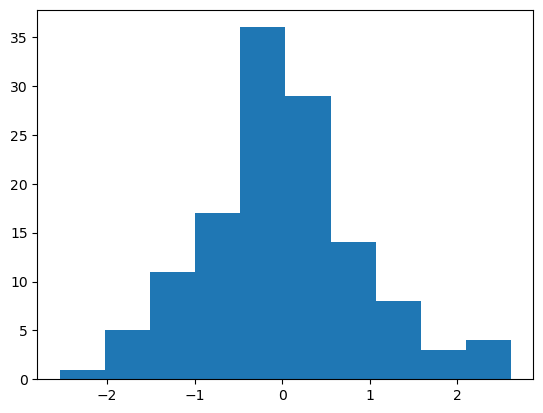

In [22]:
import matplotlib.pyplot as plt 
plt.hist(uhat.cpu().numpy().flatten())
plt.show()

## INFERENCE: 

In [25]:
gen = torch.load("trained_forward")
backward = torch.load("trained_backward")

bicogan = BiCoGAN(forward=gen, 
            backward=backward, 
            discriminator=None,
            args=None)

/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_87575/516470868.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load("trained_forward")
/var/folde

In [26]:
def GenerateCounterfactuals(self, state, action, reward, next_state):
        """given a specific 1-step transition generate countefactual outcomes
        and insert to replay memory.
        """
        for a in range(4):
            if action != a:
                counterfactual_action = torch.tensor(a)
                for i in range(10):
                    with torch.no_grad():
                        shat, ahat, uhat = self.scm.backward(next_state.unsqueeze(0), reward.unsqueeze(0)) # backward. 
                        action_tensor = nn.functional.one_hot(counterfactual_action, 4).to(device)
                        obsaction_tensor = nn.functional.one_hot(torch.tensor(action), 4).to(device)
                        s_hat, done_hat, reward_hat = self.scm.forward(state.unsqueeze(0), 
                                                                       obsaction_tensor.unsqueeze(0), 
                                                                       uhat)
                    # self.Counterfactual.store_transition(state.cpu().numpy(), 
                    #                                 action, 
                    #                                 reward_hat[0].item(), 
                    #                                 s_hat.cpu().numpy(), done_hat > 0)

### Generate counterfactual data. 

In [27]:
d_aug = []
# s, a, r, s_
for s, a, r, s_, done in dataset: 
    for a_ in range(4):
        if torch.argmax(a).cpu().item() != a_:
            counterfactual_action = torch.tensor(a_)
            with torch.no_grad():
                shat, ahat, uhat = bicogan.backward(s_.unsqueeze(0), 
                                                    r.unsqueeze(0)) # backward. 
                action = nn.functional.one_hot(counterfactual_action, 4).to(device)
                s_hat, donehat,  reward = bicogan.forward(s.unsqueeze(0), 
                                                          action.unsqueeze(0), 
                                                          uhat)
                toappend = [s.cpu().numpy(), 
                            a_, 
                            reward[0].item() , 
                            s_hat.cpu().numpy(), 
                            donehat[0].item() > 0 ]
                d_aug.append(toappend)

In [28]:
# random.choice(range(4))
torch.argmax(a).cpu().item()

2

In [29]:
# generate just 1 cf- data point. 
d_aug = []
# s, a, r, s_
for s, a, r, s_, done in tqdm.tqdm(dataset): 
    a_ = torch.argmax(a).cpu().item() #random.choice(range(4))
    while a_ == torch.argmax(a).cpu().item():
        a_ =  random.choice(range(4))
    
    counterfactual_action = torch.tensor(a_)
    with torch.no_grad():
        shat, ahat, uhat = bicogan.backward(s_.unsqueeze(0), 
                                            r.unsqueeze(0)) # backward. 
        action = nn.functional.one_hot(counterfactual_action, 4).to(device)
        s_hat, donehat,  reward = bicogan.forward(s.unsqueeze(0), 
                                                    action.unsqueeze(0), 
                                                    uhat)
        toappend = [s.cpu().numpy(), 
                    a_, 
                    reward[0].item() , 
                    s_hat.cpu().numpy(), 
                    donehat[0].item() > 0 ]
        d_aug.append(toappend)

100%|████████████████████████████████████████████████████████████████████████████████████████| 47062/47062 [00:07<00:00, 6051.72it/s]


In [30]:
len(d_aug)

47062

In [31]:
d_aug[0]

[array([ 0.00326729,  1.4007356 ,  0.33091703, -0.45263883, -0.00377909,
        -0.07495759,  0.        ,  0.        ], dtype=float32),
 1,
 -0.525330662727356,
 array([[ 0.2512148 ,  1.0998038 ,  0.34717417, -0.6013429 , -0.12733069,
          0.01942215,  0.10060097,  0.12164406]], dtype=float32),
 False]

In [21]:
with open("data/lunarLander-1", 'wb') as f: 
    pkl.dump(d_aug, f)
    f.close() 